In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import lightgbm as lgb
from scipy.stats import randint
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


file_path_train = os.getcwd()+'/train.csv'
file_path_test = os.getcwd()+'/test.csv'

train_raw = pd.read_csv(file_path_train)
test_raw = pd.read_csv(file_path_test)

In [2]:
len(train_raw)

6895

In [3]:
len(test_raw)

767

In [4]:
df_raw = pd.concat([train_raw, test_raw], ignore_index=True)

In [5]:
df_raw.columns

Index(['id', 'short_name', 'overall', 'potential', 'value_eur', 'wage_eur',
       'birthday_date', 'height_cm', 'weight_kg', 'club_name', 'league_name',
       'league_level', 'club_jersey_number', 'club_loaned_from', 'club_joined',
       'club_contract_valid_until', 'nationality_name', 'nation_jersey_number',
       'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'work_rate', 'body_type', 'real_face',
       'release_clause_eur', 'player_tags', 'player_traits', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'pow

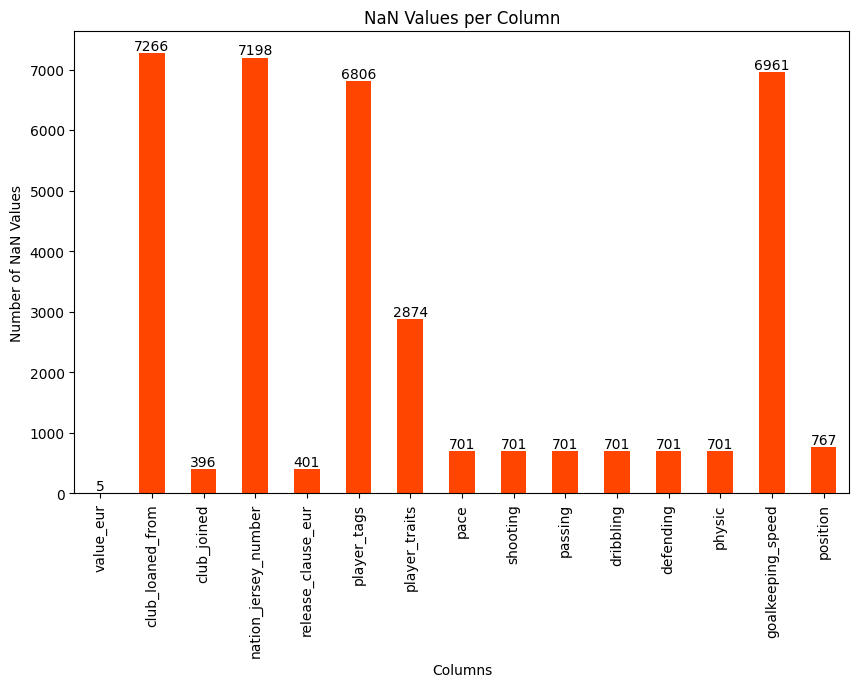

In [6]:
# Check for NaN values and filter columns with more than 0 NaN
na_counts = df_raw.isna().sum()
columns_with_nan = na_counts[na_counts > 0].index

# Plot the number of NaN values per column
ax = na_counts[columns_with_nan].plot(kind='bar', figsize=(10, 6), color='orangered')
plt.title('NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')

# Add numbers on top of each bar
for i, v in enumerate(na_counts[columns_with_nan]):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()

In [7]:
df_raw['position'].value_counts()

position
RCB    631
GK     631
LCB    631
RB     463
LB     463
ST     428
RCM    423
LCM    423
RM     369
LM     369
CAM    263
RDM    201
LS     201
RS     201
LDM    201
CB     167
RW     166
LW     166
CDM    151
LWB    104
RWB    104
CM      75
LF      32
RF      32
Name: count, dtype: int64

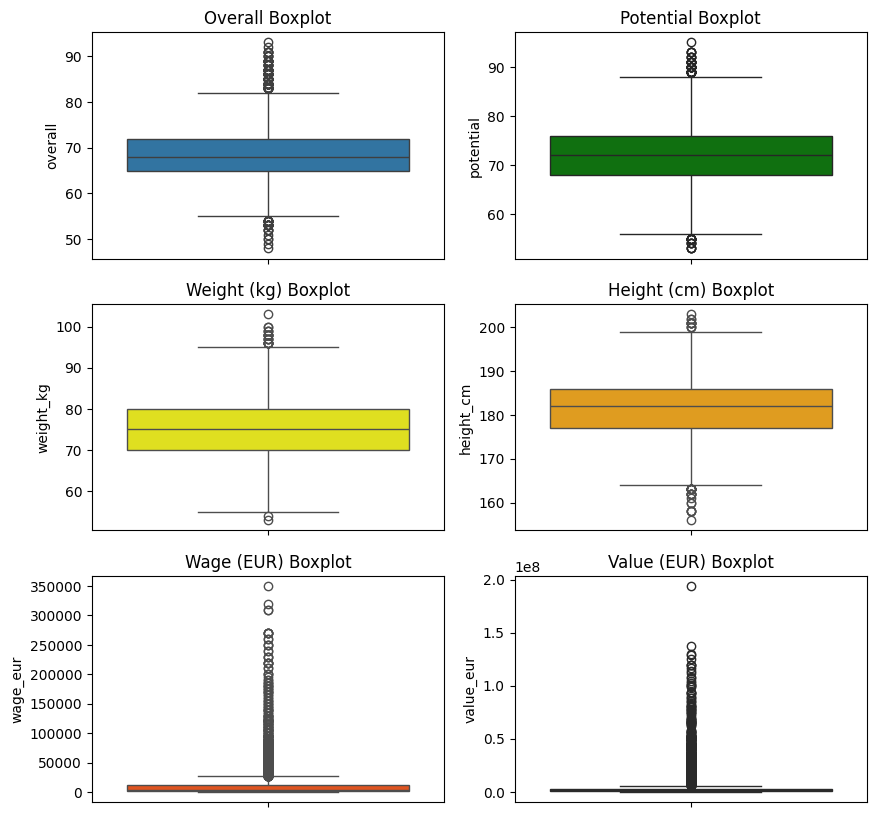

In [8]:

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
sns.boxplot(df_raw['overall'], ax = axes[0,0])
axes[0,0].set_title('Overall Boxplot')

sns.boxplot(df_raw['potential'], ax = axes[0,1], color='green')
axes[0,1].set_title('Potential Boxplot')

sns.boxplot(df_raw['weight_kg'], ax = axes[1,0], color = 'yellow')
axes[1,0].set_title('Weight (kg) Boxplot')

sns.boxplot(df_raw['height_cm'], ax = axes[1,1], color='orange')
axes[1,1].set_title('Height (cm) Boxplot')

sns.boxplot(df_raw['wage_eur'], ax = axes[2,0], color='orangered')
axes[2,0].set_title('Wage (EUR) Boxplot')

sns.boxplot(df_raw['value_eur'], ax = axes[2,1], color='darkred')
axes[2,1].set_title('Value (EUR) Boxplot')


plt.show()

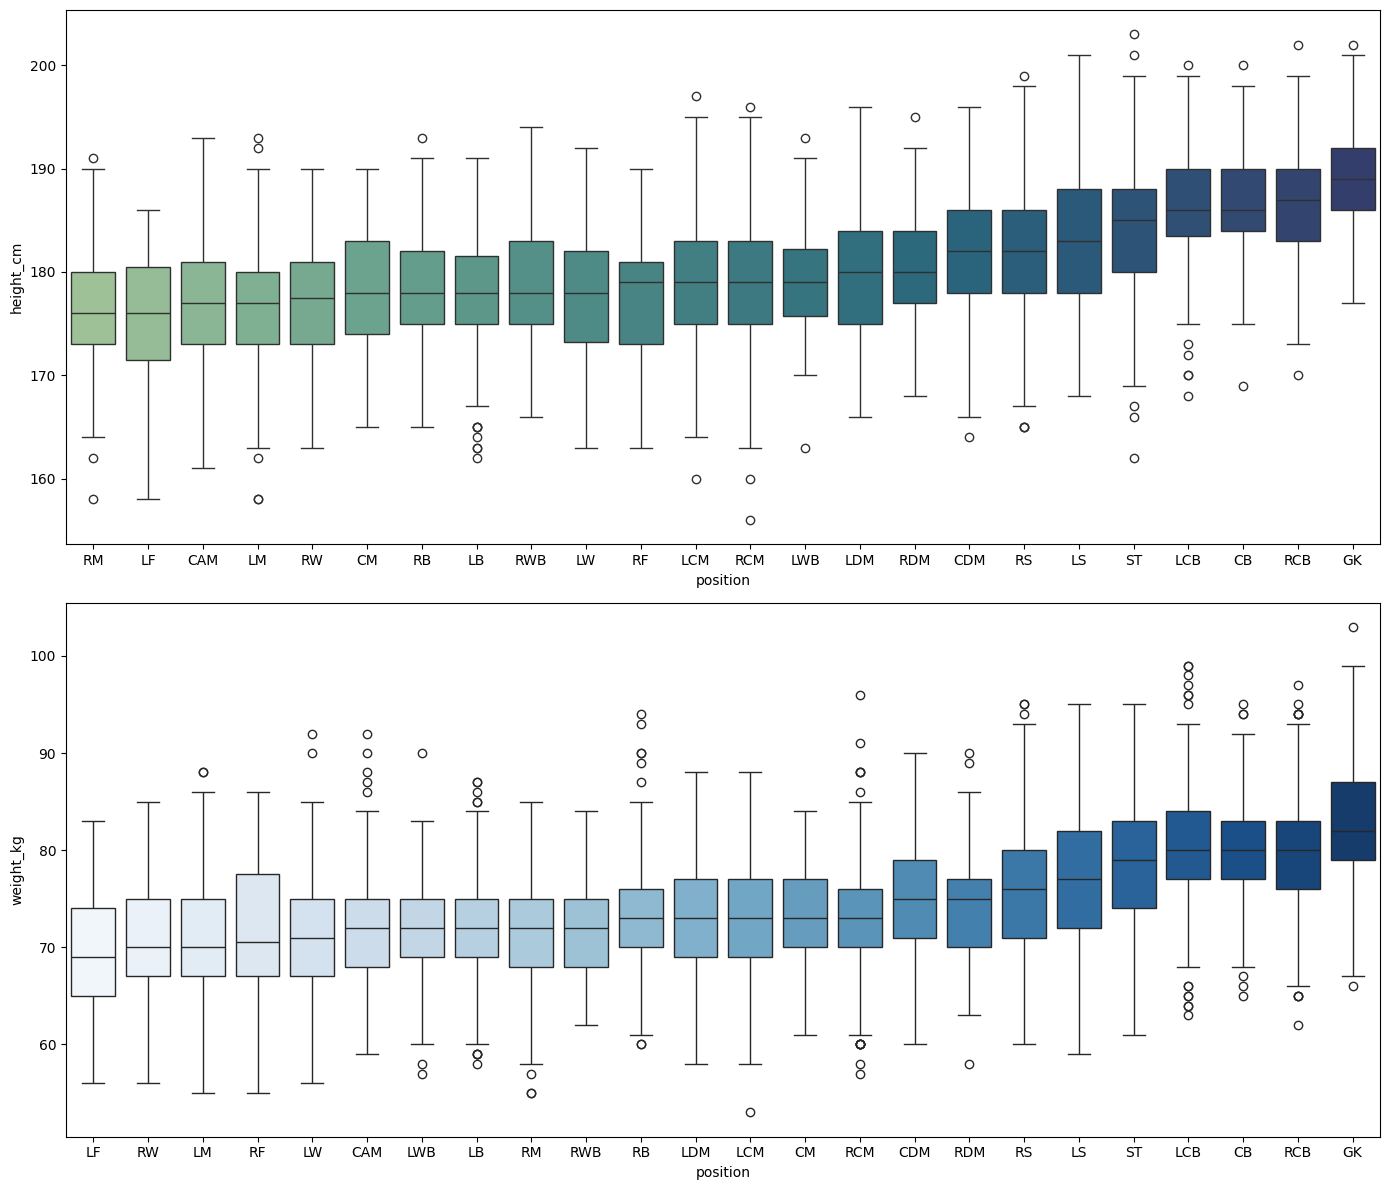

In [9]:
# Calculate the median height for each position
median_heights = df_raw.groupby('position')['height_cm'].median().sort_values(ascending=True)

# Calculate the median weight for each position
median_weights = df_raw.groupby('position')['weight_kg'].median().sort_values(ascending=True)

# Suppress the deprecation warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Create a subplot with two axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))

# Plot the boxplot for height on the first axis
sns.boxplot(ax=axes[0], x='position', y='height_cm', data=df_raw, palette='crest', order=median_heights.index)

# Plot the boxplot for weight on the second axis
sns.boxplot(ax=axes[1], x='position', y='weight_kg', data=df_raw, palette='Blues', order=median_weights.index)

# Adjust layout
plt.tight_layout()

plt.show()

In [10]:
df_raw.loc[df_raw['goalkeeping_speed'] > 0, 'position'].value_counts() # Imputation: 0, field players have no goalkeeping speed.

position
GK    631
Name: count, dtype: int64

In [11]:
#df_raw['goalkeeping_speed'] = df_raw['goalkeeping_speed'].fillna(0)

In [12]:
goalkeeper_pred = df_raw[6895:].apply(lambda x: pd.Series({'id': x['id'], 'position': 'GK' if x['goalkeeping_speed'] > 0 else x['position']}), axis=1).dropna()

goalkeeper_pred['id'] = goalkeeper_pred['id'].astype(int)

In [13]:
df_raw = df_raw[pd.isna(df_raw['goalkeeping_speed'])]

In [14]:
columns_to_impute = ['value_eur','pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

knn_imputer = KNNImputer(n_neighbors=50)  

imputed_data = knn_imputer.fit_transform(df_raw[columns_to_impute])

df_raw[columns_to_impute] = imputed_data

In [15]:
def one_hot_encoding(data, column):
    data = data.copy() # create deep copy of data

    dummy = pd.get_dummies(data[column]).astype(int) # get dummies
    data = pd.concat([data, dummy], axis=1) # add dummy columns to dataframe 
    data = data.drop(columns = column)

    return data


In [16]:
df_raw = one_hot_encoding(df_raw, 'weak_foot')
df_raw = df_raw.rename(columns={1:'wf_one_star', 2:'wf_two_stars', 3:'wf_three_stars', 4:'wf_four_stars', 5:'wf_five_stars'})

df_raw = one_hot_encoding(df_raw, 'skill_moves')
df_raw = df_raw.rename(columns={1:'sm_one_star', 2:'sm_two_stars', 3:'sm_three_stars', 4:'sm_four_stars', 5:'sm_five_stars'})


In [17]:
df_raw['wr_high_def'] = df_raw['work_rate'].str.contains('High/').astype(int)
df_raw['wr_low_def'] = df_raw['work_rate'].str.contains('Low/').astype(int)

df_raw['wr_high_atk'] = df_raw['work_rate'].str.contains('/High').astype(int)
df_raw['wr_low_atk'] = df_raw['work_rate'].str.contains('/Low').astype(int)

In [18]:
encoder = LabelEncoder()
df_raw['preferred_foot'] = encoder.fit_transform(df_raw['preferred_foot'])
df_raw['position'] = encoder.fit_transform(df_raw['position'])


In [19]:
features = ['position','overall', 'potential', 'value_eur', 'wage_eur','height_cm', 'weight_kg', 'club_jersey_number', 'preferred_foot',
            'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'wr_high_def', 'wr_low_def', 'wr_high_atk', 'wr_low_atk',
            'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
            'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 
            'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
            'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
            'wf_three_stars', 'wf_four_stars', 'wf_five_stars', 'sm_four_stars', 'sm_five_stars']

#'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking','goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',

In [20]:
df = df_raw[features]

In [21]:
# tr = df[:6895]
# te = df[6895:]

tr = df[:6264]
te = df[6264:]

In [22]:
X_train = tr.drop('position', axis=1)
y_train = tr['position']

X_test = te.drop('position', axis=1)

In [24]:
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=2)

# Define the hyperparameter grid to search
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=2)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy: ", random_search.best_score_)

rf_best_params = random_search.best_params_

Best Hyperparameters: {'bootstrap': False, 'max_depth': 18, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 146}
Best Accuracy:  0.40181863846257804


In [25]:
rf_best_params

{'bootstrap': False,
 'max_depth': 18,
 'min_samples_leaf': 8,
 'min_samples_split': 16,
 'n_estimators': 146}

In [26]:
rf = RandomForestClassifier(**rf_best_params)

rf_best_model = rf.fit(X_train, y_train)

In [27]:
feature_importances = rf_best_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

display(feature_importance_df.head(60))
#display(feature_importance_df.tail(15))

,Feature,Importance
7,preferred_foot,0.082213
18,attacking_crossing,0.047936
20,attacking_heading_accuracy,0.044859
40,mentality_positioning,0.044447
12,defending,0.044385
46,defending_sliding_tackle,0.038867
36,power_strength,0.032757
39,mentality_interceptions,0.032541
19,attacking_finishing,0.031888
9,shooting,0.031543


In [ ]:
# model = lgb.LGBMClassifier()

# # Define the parameter grid for random search
# param_dist = {
#     'num_leaves': randint(6, 50),
#     'min_child_samples': randint(100, 500),
#     'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#     'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
# }

# # Perform randomized search with cross-validation
# random_search = RandomizedSearchCV(
#     model, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, verbose=1, n_jobs=-1
# )

# # Fit the model
# random_search.fit(X_train, y_train)

# # Print the best parameters and their corresponding accuracy
# print("Best Parameters: ", random_search.best_params_)
# print("Best Accuracy: ", random_search.best_score_)

# lgb_params = random_search.best_params_

# lgb_model = lgb.LGBMRegressor(**lgb_params)
# lgb_model.fit(X_train, y_train)

# lgb_preds = lgb_model.predict(X_test)

# lgb_preds = np.round(lgb_preds).astype(int)
# decoded_lgb_preds = encoder.inverse_transform(lgb_preds)

In [ ]:
import xgboost as xgb


xgboost = xgb.XGBClassifier(random_state=0)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': range(50, 201, 50),
    'max_depth': range(3, 10),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5, 1, 5],
    'reg_lambda': [0, 0.1, 0.5, 1, 5]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(xgboost, param_distributions=param_dist,
                                   n_iter=10, scoring='accuracy',
                                   cv=5, verbose=1, n_jobs=-1, random_state=0)

# Fit the model with the best parameters found
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", random_search.best_params_)
print("Best Accuracy: ", random_search.best_score_)

xgb_best_params = random_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:  {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Best Accuracy:  0.39112570724829104


In [ ]:
xgb_best = xgb.XGBClassifier(**xgb_best_params)

xgb_best_model = xgb_best.fit(X_train, y_train)

xgb_pred = xgb_best_model.predict(X_test)

decoded_xgb_preds = encoder.inverse_transform(xgb_pred)

In [29]:
rf_preds = rf_best_model.predict(X_test)
decoded_rf_preds = encoder.inverse_transform(rf_preds)

In [ ]:
decoded_xgb_preds

array(['RB', 'LCB', 'ST', 'RM', 'RB', 'RB', 'LCM', 'CDM', 'RCB', 'ST',
       'CAM', 'LB', 'RCB', 'LCB', 'LCM', 'LB', 'ST', 'RB', 'RCM', 'RM',
       'ST', 'RCM', 'RB', 'RB', 'LB', 'RDM', 'RB', 'LB', 'LM', 'RCB',
       'LM', 'RCB', 'LCM', 'RCB', 'RCM', 'LB', 'RCB', 'LCM', 'ST', 'RCB',
       'RB', 'LB', 'RCB', 'CAM', 'LB', 'ST', 'LM', 'ST', 'RB', 'RB', 'LB',
       'ST', 'LB', 'LM', 'ST', 'RCB', 'CAM', 'CAM', 'RCM', 'RB', 'RCB',
       'LCB', 'ST', 'RCM', 'LCM', 'LCB', 'LCM', 'RB', 'RCM', 'RCM', 'RM',
       'RCB', 'LM', 'LS', 'RCM', 'RB', 'CAM', 'RCB', 'RW', 'LCB', 'LB',
       'LCM', 'RDM', 'ST', 'LM', 'RB', 'RM', 'RDM', 'LM', 'RCB', 'ST',
       'ST', 'LB', 'LM', 'ST', 'RCB', 'LB', 'LCM', 'LCM', 'RCB', 'LM',
       'ST', 'LCB', 'RM', 'RB', 'ST', 'LCM', 'RCB', 'RCB', 'LM', 'ST',
       'RB', 'LCB', 'LB', 'RCM', 'ST', 'RCM', 'LB', 'LCM', 'ST', 'LCM',
       'RB', 'ST', 'LCM', 'RB', 'LCM', 'RM', 'RM', 'RS', 'RCM', 'LB',
       'ST', 'RCM', 'LM', 'LM', 'LB', 'RCM', 'ST', 'CAM', 'RCB', 

In [30]:
decoded_rf_preds

array(['RB', 'LCB', 'ST', 'RM', 'RB', 'RB', 'LCM', 'RCM', 'RCB', 'ST',
       'CAM', 'LB', 'RCB', 'LCB', 'LCM', 'LB', 'ST', 'RB', 'RCM', 'RM',
       'ST', 'RCM', 'RB', 'RCB', 'LB', 'LCM', 'RB', 'LB', 'LM', 'RCB',
       'RM', 'RCB', 'LCM', 'RCB', 'RCM', 'LB', 'RCB', 'LCM', 'ST', 'RCB',
       'RB', 'LB', 'RCB', 'RCM', 'LB', 'ST', 'LM', 'ST', 'RB', 'RB', 'LB',
       'ST', 'LB', 'ST', 'ST', 'RCB', 'LM', 'CAM', 'RCM', 'RB', 'RCB',
       'LCB', 'ST', 'RCM', 'LCM', 'LCB', 'RB', 'RB', 'RCM', 'LCM', 'RM',
       'RCB', 'LM', 'ST', 'RCM', 'RB', 'LCM', 'RCB', 'LM', 'LCB', 'LB',
       'RDM', 'RCM', 'ST', 'RM', 'RB', 'RM', 'RCM', 'LM', 'RCB', 'ST',
       'ST', 'LCB', 'LM', 'ST', 'RCB', 'LB', 'LCM', 'LCM', 'RCB', 'LM',
       'ST', 'LCB', 'RM', 'RB', 'ST', 'LCM', 'RCB', 'RCB', 'LM', 'ST',
       'RB', 'LCB', 'LB', 'RCM', 'ST', 'RB', 'LCB', 'RCM', 'ST', 'LCM',
       'RB', 'ST', 'LCM', 'RB', 'LCM', 'RM', 'RM', 'ST', 'RCM', 'LB',
       'ST', 'RCM', 'RM', 'LM', 'LB', 'RCM', 'ST', 'RCM', 'RCB', 

In [31]:
decoded_rf_preds = pd.DataFrame({"id": df_raw[6264:]["id"], "position": decoded_rf_preds})

rf_merged_df = pd.merge(goalkeeper_pred, decoded_rf_preds, how='outer', on='id')

# Sort the merged DataFrame based on the order in test_raw
rf_result = pd.merge(test_raw['id'], rf_merged_df, how='left', on='id')

rf_result['position'] = rf_result['position_x'].fillna(rf_result['position_y'])

In [ ]:
decoded_xgb_preds = pd.DataFrame({"id": df_raw[6264:]["id"], "position": decoded_xgb_preds})

xgb_merged_df = pd.merge(goalkeeper_pred, decoded_xgb_preds, how='outer', on='id')

# Sort the merged DataFrame based on the order in test_raw
xgb_result = pd.merge(test_raw['id'], xgb_merged_df, how='left', on='id')

xgb_result['position'] = xgb_result['position_x'].fillna(xgb_result['position_y'])

In [32]:
#Produce .csv for kaggle testing 

test_predictions_submit = pd.DataFrame({"id": test_raw["id"], "position": rf_result['position']})
#test_predictions_submit = pd.DataFrame({"id": test_raw["id"], "position": xgb_result['position']})
#test_predictions_submit = pd.DataFrame({"id": test_raw["id"], "price": decoded_xgb_preds})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)

In [33]:
test_predictions_submit.head(20)

,id,position
0,215562,RB
1,248311,LCB
2,223933,ST
3,232546,RM
4,189217,RB
5,219793,GK
6,258881,RB
7,238062,LCM
8,233564,RCM
9,262555,RCB
